In [1]:
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten,Dropout
from keras.models import Model
from keras.models import load_model

from tensorflow.keras.utils import plot_model
import pydot
import graphviz
from scipy.signal import savgol_filter

In [2]:
input_step=25 #to be changed to 10,10
output_step=50

In [37]:
lstm_model = load_model("lstm_model_withencoder_"+str(input_step)+".h5")


In [38]:
encoder=load_model("encoder-simple_"+str(input_step)+".h5")

In [39]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 25, 6, 500)]      0         
                                                                 
 flatten_1 (Flatten)         (None, 75000)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               19200256  
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 100)               12900     
                                                                 
 dense_11 (Dense)            (None, 1600)              161600    
                                                                 
Total params: 19,407,652
Trainable params: 19,407,652
Non-t

In [40]:

input_shape = (input_step,6,500)
fsize=64

input_layer = Input(shape=(input_shape))
hidden_layer_0=encoder(input_layer)
hidden_layer_1 =Reshape((input_step,fsize))(hidden_layer_0)
output_layer = lstm_model(hidden_layer_1)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mae')

In [41]:
X2=np.load("X2_"+str(input_step)+".npy")
Y2=np.load("Y2_"+str(output_step)+".npy",
           allow_pickle=True)

In [42]:
predicted_y=model.predict(X2)

1623/1623 [==============================] - 25s 15ms/step


In [43]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y2,predicted_y)

0.004437653436045513

In [44]:
model.save("combined_model_lstm_encoder_"+str(input_step)+".h5")

# the prediction procuss

In [4]:
model=load_model("combined_model_lstm_encoder_"+str(input_step)+".h5")

In [5]:
model_cnn=load_model("Cnn_lstm_model_"+str(input_step)+".h5")

In [6]:
test_data=np.load("test_data.npy",allow_pickle=True)

In [7]:
min_max=np.load("min_max.npy")

In [8]:
len(test_data)

56

In [24]:
x=test_data[50].drop(["SOH","charge_policy"],axis=1)
y=test_data[50]["SOH"]

In [25]:
def normalization(x,min_max):
    t=np.zeros((len(x),6,500))
    for i in range(len(x)):
        x["Ic"][i]= (x["Ic"][i]-min_max[0])/(min_max[1]-min_max[0])
        x["Id"][i]= (x["Id"][i]-min_max[2])/(min_max[3]-min_max[2])
        x["Vc"][i]= (x["Vc"][i]-min_max[4])/(min_max[5]-min_max[4])
        x["Vd"][i]= (x["Vd"][i]-min_max[6])/(min_max[7]-min_max[6])
        x["Tc"][i]= (x["Tc"][i]-min_max[8])/(min_max[9]-min_max[8])
        x["Td"][i]= (x["Td"][i]-min_max[10])/(min_max[11]-min_max[10])
        t[i][0][0:min(500,len(x["Ic"][i]))]=x["Ic"][i][0:min(500,len(x["Ic"][i]))]
        t[i][1][0:min(500,len(x["Id"][i]))]=x["Id"][i][0:min(500,len(x["Id"][i]))]
        
        t[i][2][0:min(500,len(x["Vc"][i]))]=x["Vc"][i][0:min(500,len(x["Vc"][i]))]
        t[i][3][0:min(500,len(x["Vd"][i]))]=x["Vd"][i][0:min(500,len(x["Vd"][i]))]
        
        t[i][4][0:min(500,len(x["Tc"][i]))]=x["Tc"][i][0:min(500,len(x["Tc"][i]))]
        t[i][5][0:min(500,len(x["Td"][i]))]=x["Td"][i][0:min(500,len(x["Td"][i]))]
    
    return t

In [26]:
x=normalization(x,min_max)

In [27]:
def prepare_data(x):
    data=[]
    start=0
    end=input_step
    while (end<=len(x)):
            data.append(x[start:end])
            end=end+output_step
            start=start+output_step
    return data

In [28]:
yp_cnn=[]
yp_lstm=[]
x=prepare_data(x)
for i in range(len(x)):
    yp_cnn.append(model_cnn.predict(np.reshape(x[i],(1,input_step,6,500)),verbose=0))
    yp_lstm.append(model.predict(np.reshape(x[i],(1,input_step,6,500)),verbose=0))
   


In [29]:
np.shape(yp_cnn)

(16, 1, 50)

In [30]:

yp_cnn=np.reshape(yp_cnn,(np.shape(yp_cnn)[0]*output_step))
#yp_cnn=savgol_filter(yp_cnn , 35, 2)
yp_lstm=np.reshape(yp_lstm,(np.shape(yp_lstm)[0]*output_step))
#yp_lstm=savgol_filter(yp_lstm , 35, 2)

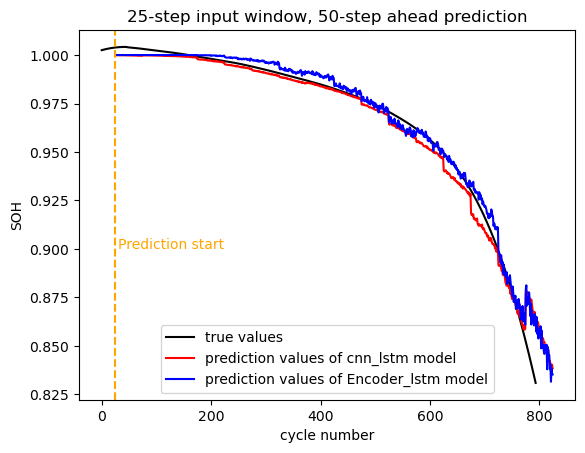

In [31]:
fig, ax = plt.subplots()
plt.plot(y,color="black",label="true values")
plt.plot(range(input_step,len(yp_cnn)+input_step,1),yp_cnn,label="prediction values of cnn_lstm model",color="red")
plt.plot(range(input_step,len(yp_lstm)+input_step,1),yp_lstm,label="prediction values of Encoder_lstm model",color="blue")
plt.axvline(x=input_step,color='orange', linestyle='--')
plt.text(input_step+5, 0.9, 'Prediction start',color="orange")
plt.legend()
plt.xlabel("cycle number")
plt.ylabel("SOH")
plt.title(str(input_step)+"-step input window, "+str(output_step)+"-step ahead prediction")
fig.savefig("prediction-"+str(input_step)+".pdf", format="pdf", dpi=1200)

# evaluation

In [60]:
X2=np.load("X2_"+str(input_step)+".npy")
Y2=np.load("Y2_"+str(output_step)+".npy",allow_pickle=True)

In [61]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
from sklearn import metrics
import statistics 
ytrue=Y2
ylstm=model.predict(X2)
ycnn=model_cnn.predict(X2)


mael = metrics.mean_absolute_error(ylstm, ytrue)
maecnn = metrics.mean_absolute_error(ycnn, ytrue)
mse1 = metrics.mean_squared_error(ylstm, ytrue)
msecnn = metrics.mean_squared_error(ycnn, ytrue)
rmse1 = np.sqrt(mse1)
rmsecnn = np.sqrt(msecnn)# or mse**(0.5)  


print("Results of sklearn.metrics:")
print("MAE E-lstm:",mael)
print("MAE cnn-lstm:",maecnn)
print("MSE E-lstm:", mse1)
print("MSE cnn-lstm:", msecnn)
print("RMSE E-lstm:", rmse1)
print("RMSE cnn-lstm:", rmsecnn)




1623/1623 [==============================] - 28s 17ms/step


In [ ]:
MAPEL=MAPE(ylstm,Y2)
MAPEcnn=MAPE(ycnn,Y2)
print("MAPE E-lstm: ",MAPEL)
print("MAPE cnn-lstm: ",MAPEcnn)